In [1]:
from pettingzoo.mpe import simple_spread_v2
from pettingzoo.utils import AssertOutOfBoundsWrapper
from pettingzoo.utils import aec_to_parallel

env = simple_spread_v2.env(N=1, local_ratio=0.5, max_cycles=105, continuous_actions=False, 
# render_mode="human"
)

env = AssertOutOfBoundsWrapper(env)
env = aec_to_parallel(env)

import time
import pettingzoo
pettingzoo.__version__
import sys
import torch  
import gym
# from tqdm import tqdm
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class A2CTD0:
    def __init__(self, env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma) -> None:
        self.env = env
        self.obs_size = obs_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_episodes = num_episodes
        self.num_steps = num_steps
        self.gamma = gamma

        # self.model = ActorCriticSingleAgent(self.obs_size * self.env.observation_space.shape[0] + 1, self.output_size, self.hidden_size, self.learning_rate)
    
    def _get_action(self, actor_act_pred):
        # Sample an action according the probs the network just output.
        action = np.random.choice(self.output_size, p=np.squeeze(actor_act_pred))
        return action

    def _obs_to_tensor(self, obs):
        state_tensor = torch.flatten(F.one_hot(torch.tensor(obs, dtype=torch.int64), num_classes=self.obs_size))
        # add a bias bit with a value of 1 in front of the one hot vector
        state_tensor = torch.cat((torch.tensor([1.0]), state_tensor))
        return state_tensor

    def _show_episode_results(self, episode, steps, state, all_losses, average_lengths, frequency):
        if episode % frequency == 0:
            # make an array of the value of each state currently
            # make an empty array for the values of each state of shape 10x10
            state_values = np.zeros((10, 10))
            for i in range(1, 11):
                for j in range(1, 11):
                    state_tensor = self._obs_to_tensor([i, j])
                    value, _ = self.model.forward(state_tensor.float())
                    state_values[i-1][j-1] = value.detach().numpy()
            # show the value of each state with matplot lib
            # plt.imshow(state_values)
            # plt.show()
                # sys.stdout.write("\nState: " + str(i) + " Value: " + str(state_values))
            sys.stdout.write("\nLoss: " + str(all_losses[-1]) 
                # + "\nCurrent State: " + str(state)
                )
            # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
            sys.stdout.write("\nepisode: {}, total length: {}, average length of prev 10: {} \n".format(episode, steps, average_lengths[-1]))

    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        episode_rewards = []
        # average episode length
        average_lengths = []
        all_entropies = []
        all_losses = []

        for episode in range(self.num_episodes):
            rewards = []
            done = False
            i = 1

            state = self.env.reset()
            steps = 0
            # enable n step actor critic. 
            while not done:
                state_tensor = self._obs_to_tensor(state)
                critic_td_error, actor_act_pred = self.model.forward(state_tensor.float())
                # drop the tensor dimension and computational graph info
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_action(detached_act_pred)

                # Calculate the log probability of the action we've taken
                log_prob = torch.distributions.Categorical(actor_act_pred).log_prob(torch.tensor(action))

                # Calculate the entropy/ uncertainty of the policy term. This is used to encourage exploration
                entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))
                new_state, reward, done, _, _ = self.env.step(action)
                steps += 1

                state = new_state
                
                state_tensor = self._obs_to_tensor(state)
                if not done:
                  q_val_tensor, _ = self.model.forward(state_tensor.float())
                else:
                    q_val_tensor = torch.tensor(0)
                    all_lengths.append(steps)
                    average_lengths.append(np.mean(all_lengths[-10:]))
                td_error = reward + self.gamma * q_val_tensor - critic_td_error
        
                # update actor critic
                actor_loss = -log_prob * (reward + self.gamma * q_val_tensor.item() - critic_td_error.item())
                actor_loss *= i
                critic_loss = 0.5 * td_error ** 2
                critic_loss *= i

                ac_loss = actor_loss + critic_loss + 0.001 * entropy

                ac_optimizer.zero_grad()
                ac_loss.backward()
                ac_optimizer.step()
                # all_entropies.append(entropy)
                all_losses.append(ac_loss.detach().numpy())
                i *= self.gamma
            if done:
              episode_rewards.append(np.sum(rewards))
            self._show_episode_results(episode, steps, state, all_losses, average_lengths)
            
        return all_lengths, average_lengths, all_entropies, all_losses, episode_rewards

In [3]:
"""
This is a single agent actor-critic implementation.
It is specifically designed to work with the four rooms environment, but it should work with any gym environment.
"""

import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd


def obs_to_tensor(obs: np.array) -> torch.Tensor:
    # initialize an empty np array
    obs_tensor = np.array([])
    for _, value in obs.items():
        obs_tensor = np.concatenate((obs_tensor, value))
    return torch.Tensor(obs_tensor)



In [4]:
class ActorCriticCentralizedMultiAgent(nn.Module):
    """
    A simple, but flexible, implementation of the actor-critic algorithm.
    """
    def __init__(self, num_inputs, num_actions, actions_per_agent, hidden_size, learning_rate=3e-4):
        super(ActorCriticCentralizedMultiAgent, self).__init__()

        self.num_actions = num_actions
        self.actions_per_agent = actions_per_agent
        # estimate the value function
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, hidden_size)
        self.critic_linear3 = nn.Linear(hidden_size, len(self.actions_per_agent))

        # estimate the policy distribution
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, hidden_size)
        self.actor_linear3 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        """
        Do inference to calculate the action probabilities and the state value.
        """
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        # softmax effectively generates a probability for each of our output options
        policy_dist = self.actor_linear2(policy_dist)
        policy_dist = self.actor_linear3(policy_dist)
        # reshape the policy dist for each actor
        policy_dist = policy_dist.view((len(self.actions_per_agent), self.actions_per_agent[0]))

        policy_dist = F.softmax(policy_dist, 1)

        return value, policy_dist

In [5]:
min_vals = np.zeros((6))
max_vals = np.zeros((6))
min_adj = np.ones((6))
max_adj = np.zeros((6))

class A2CTDNCentralizedMultiAgent(A2CTD0):
    def __init__(self, env, obs_size, hidden_size, output_size, actions_per_agent, learning_rate, num_episodes, num_steps, gamma) -> None:
        super().__init__(env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma)
        self.actions_per_agent = actions_per_agent

        self.model = ActorCriticCentralizedMultiAgent(self.obs_size + 1, self.output_size, actions_per_agent, self.hidden_size, self.learning_rate)
    
    def _get_actions(self, actor_act_pred, num_agents):
        # Sample an action according the probs the network just output.
        idx = 0
        actions = {}
        for agent in env.agents:
            action_space_size = env.action_space(agent).n
            action = np.random.choice(action_space_size, p=np.squeeze(actor_act_pred[idx]))
            actions[agent] = action
            idx += 1
        return actions

    def _show_episode_results(self, episode, steps, state, all_losses, average_lengths, rewards, frequency):
        if episode % frequency == 0:
            # make an array of the value of each state currently
            # make an empty array for the values of each state of shape 10x10
            # state_values = np.zeros((10, 10))
            # for i in range(1, 11):
            #     for j in range(1, 11):
            #         state_tensor = self._obs_to_tensor([i, j])
            #         value, _ = self.model.forward(state_tensor.float())
            #         state_values[i-1][j-1] = value.detach().numpy()
            # # show the value of each state with matplot lib
            # # plt.imshow(state_values)
            # # plt.show()
            #     # sys.stdout.write("\nState: " + str(i) + " Value: " + str(state_values))
            sys.stdout.write("\nLoss: " + str(all_losses[-1]) + "\nRewards: " + str(rewards[-1]) + "\n" + "Average last 20 Rewards" + str(np.mean(rewards[-20:])))
                # + "\nCurrent State: " + str(state))
            # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
            sys.stdout.write("\nepisode: " + str(episode))
            global min_vals, max_vals, min_adj, max_adj
            sys.stdout.write("\nmin_vals: " + str(min_vals))
            sys.stdout.write("\nmax_vals: " + str(max_vals))
            sys.stdout.write("\nmin_adj: " + str(min_adj))
            sys.stdout.write("\nmax_adj: " + str(max_adj))
            #total length: {}, average length of prev 10: {} \n".format(episode, steps, average_lengths[-1]))

    def _obs_to_tensor(self, obs: np.array) -> torch.Tensor:
        # initialize an empty np array
        # we want to normalize these values so they are above 0
        # The form is: [agent.state.p_vel] + [agent.state.p_pos] + entity_pos + other_pos + comm
        # first we'll just adjust the position of the agent from -1 - 1 to 0 - 1
        # This means the second and third obs values for each agent must be added by 1 and then divided by 2
        obs_tensor = np.array([1.0])
        global min_vals, max_vals
        # track the min and max values for each observation
        for i, value in enumerate(list(obs.values())[0]):
            if value < min_vals[i]:
                min_vals[i] = value
            if value > max_vals[i]:
                max_vals[i] = value

        for _, value in obs.items():
            new_array = np.concatenate([np.array(value[0:2] + 2) / 4, np.array((value[2:4]  + 25) / 50), (np.array(value[4:]) + 25) / 50])
            global min_adj, max_adj
            for i, val in enumerate(list(new_array)):
                if val < min_adj[i]:
                    min_adj[i] = val
                if val > max_adj[i]:
                    max_adj[i] = val

            obs_tensor = np.concatenate((obs_tensor, new_array))
        return torch.Tensor(obs_tensor)

    def _combine_rewards(self, rewards):
        """
        Push the rewards into a tensor that can be handled by pytorch
        """
        return np.array(list(rewards.values())).T

    def _get_log_probs(self, actor_act_pred, actions):
        start = 0
        log_probs = []
        for agent in env.agents:
            action_space_size = env.action_space(agent).n
            log_probs.append(torch.distributions.Categorical(actor_act_pred[start: start + action_space_size]).log_prob(torch.tensor(actions[agent])))
            start += action_space_size
        return torch.concatenate(log_probs)

    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        episode_rewards = []
        # average episode length
        average_lengths = []
        all_entropies = []
        all_losses = []

        for episode in range(self.num_episodes):
            single_episode_rewards = []
            done = False
            i = 1
            G = 0
            state = self.env.reset()
            steps = 0
            step_rewards = []
            states = [state]
            dones = []
            actions = []

            # enable n step actor critic. 
            while True:
                state_tensor = self._obs_to_tensor(state)
                _, actor_act_pred = self.model.forward(state_tensor.float())
                # drop the tensor dimension and computational graph info
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_actions(detached_act_pred, len(self.env.agents))

                actions.append(action)

                # Calculate the entropy/ uncertainty of the policy term. This is used to encourage exploration
                # entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))
                # entropy_term += entropy
                new_state, rewards, done, _, _ = self.env.step(action)
                # time.sleep(.05)
                # done is a dict of agents. We only care if all agents are done
                done = all(done.values()) or len(self.env.agents) < 1
                if done:
                    break
                steps += 1

                state = new_state
                step_rewards.append(self._combine_rewards(rewards))
                dones.append(done)
                states.append(new_state)

                if len(step_rewards) >= self.num_steps:
                    if len(step_rewards) > self.num_steps:
                        step_rewards.pop(0)
                        states.pop(0)
                        dones.pop(0)
                        actions.pop(0)

                    # calculate G
                    G = 0
                    for idx, r in enumerate(step_rewards):
                        # account for the dones vector too
                        G += r * (self.gamma ** idx) * (1 - dones[idx])
                    single_episode_rewards.append(G)

                    critic_val, actor_act_pred = self.model.forward(self._obs_to_tensor(states[0]).float())
                    if len(env.agents) < 1:
                        print('where agent')
                    log_probs = self._get_log_probs(actor_act_pred, actions[0])
                    next_state_tensor = self._obs_to_tensor(states[-1])
                    if not dones[0]:
                        next_critic_value_tensor, _ = self.model.forward(next_state_tensor.float())
                    else:
                        # set a zeros tensor equal to the length of the number of agents
                        next_critic_value_tensor = torch.zeros(len(env.agents))
                    # calculate the n step td error
                    # td error = G + gamma ** self.num_steps * V(s_{t+n}) - V(s_t)
                    td_error = torch.tensor(G) + self.gamma ** self.num_steps * next_critic_value_tensor - critic_val


                    # update actor critic
                    actor_loss = -log_probs * (torch.tensor(G).detach() + self.gamma * next_critic_value_tensor.detach() - critic_val.detach())
                    actor_loss *= i
                    critic_loss = 0.5 * td_error ** 2

                    ac_loss = actor_loss + critic_loss# + 0.001 * entropy

                    ac_optimizer.zero_grad()
                    ac_loss.backward(
                        #torch.ones_like(ac_loss)
                    )
                    ac_optimizer.step()
                    # all_entropies.append(entropy)
                    all_losses.append(ac_loss.detach().numpy())
                    i *= self.gamma


            all_lengths.append(steps)
            average_lengths.append(np.mean(all_lengths[-10:]))
            episode_rewards.append(np.sum(single_episode_rewards))
            self._show_episode_results(episode, steps, states, all_losses, average_lengths, episode_rewards, 20)
            
        return all_lengths, average_lengths, all_entropies, all_losses, episode_rewards

In [6]:
hidden_size = 64
learning_rate = 3e-4

# Constants
gamma = 0.99
max_episodes = 5000
num_steps = 4

obs_dict = env.reset()
# env.render()
obs_size = obs_to_tensor(obs_dict).shape[0]
output_size = 0
actions_per_agent = []

for i in range(len(env.agents)):
    output_size += env.action_space(env.agents[i]).n
    actions_per_agent.append(env.action_space(list(obs_dict.keys())[i]).n)

agent = A2CTDNCentralizedMultiAgent(env, obs_size, hidden_size, output_size, actions_per_agent, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)

all_lengths, average_lengths, all_entropies, all_losses, episode_rewards = agent.train()



Loss: [50.50892065]
Rewards: -678.1507109187685
Average last 20 Rewards-678.1507109187685
episode: 0
min_vals: [-1.29576015 -1.27084017 -3.39193153 -2.06174564  0.          0.        ]
max_vals: [0.56543154 0.89990234 0.         0.03940725 3.46685863 2.88465214]
min_adj: [0.17605996 0.18228996 0.43216136 0.45876512 0.51054186 0.51567   ]
max_adj: [0.6413579  0.72497559 0.49095666 0.50078815 0.56933713 0.557693  ]
Loss: [49.42041223]
Rewards: -839.765095598309
Average last 20 Rewards-529.0525971927334
episode: 20
min_vals: [-1.82312644 -1.62287951 -5.63779783 -4.23744869 -7.71154737 -1.94296205]
max_vals: [1.92041171 1.22299194 7.43463039 2.13770986 5.05118036 3.5037291 ]
min_adj: [0.04421839 0.09428012 0.38724405 0.41525102 0.34576905 0.46114075]
max_adj: [0.9801029  0.80574799 0.64869261 0.54275423 0.60102361 0.57007456]
Loss: [-1.55348841]
Rewards: -620.587268549227
Average last 20 Rewards-711.778848750033
episode: 40
min_vals: [-1.82312644 -1.62287951 -5.63779783 -4.23744869 -8.739

In [ ]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

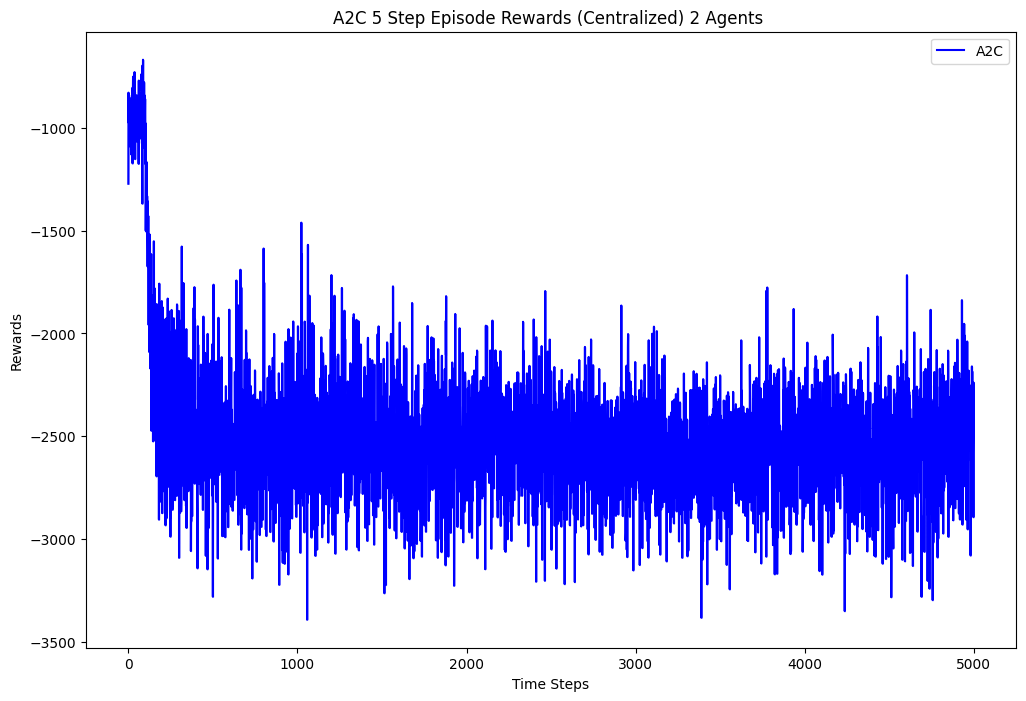

In [ ]:
plot_curves([np.array([episode_rewards])], ["A2C"], ["blue"], "Rewards", "A2C 5 Step Episode Rewards (Centralized) 1 Agent")

In [ ]:
# save episode rewards to a json file
import json

with open('simple_spread_a2c_5step_rewards_5_local_normalized_obs_episodes_len_100.json', 'w') as f:
    json.dump(episode_rewards, f)